## The quantum stuff

#### Questions:
ahs_program_1 = get_ahs_program(register_1) what info can I get from this?

Structure of the notebook:
- [Build the AtomsArrangement](#build_atoms)
- [Run on QuEra](#run)
- [Analyse results](#analyse)

In [57]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import json

from scipy.optimize import minimize
from scipy import constants

k_b = constants.physical_constants['Boltzmann constant in eV/K'][0]

from pymatgen.core.structure import Structure, Molecule
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer, PointGroupAnalyzer
from pymatgen.io.ase import AseAtomsAdaptor

from ase.visualize import view

from utils import cut_graphene_rectangle
from random_structures import *
from QUBO_models import *

from braket.ahs.atom_arrangement import AtomArrangement, SiteType
from braket.ahs.driving_field import DrivingField
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation


def vview(structure):
    view(AseAtomsAdaptor().get_atoms(structure))

eV_to_rad_s = 1.5193e+15 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Build the AtomsArrangement
<a id="build_atoms"></a>

In [3]:
def show_register(
    register: AtomArrangement,
    blockade_radius: float = 0.0,
    what_to_draw: str = "bond",
    show_atom_index: bool = True,
):
    """Plot the given register

    Args:
        register (AtomArrangement): A given register
        blockade_radius (float): The blockade radius for the register. Default is 0
        what_to_draw (str): Either "bond" or "circle" to indicate the blockade region.
            Default is "bond"
        show_atom_index (bool): Whether showing the indices of the atoms. Default is True

    """
    filled_sites = [site.coordinate for site in register if site.site_type == SiteType.FILLED]
    empty_sites = [site.coordinate for site in register if site.site_type == SiteType.VACANT]

    plt.figure(figsize=(7, 7))
    if filled_sites:
        plt.plot(
            np.array(filled_sites)[:, 0], np.array(filled_sites)[:, 1], "r.", ms=15, label="filled"
        )
    if empty_sites:
        plt.plot(
            np.array(empty_sites)[:, 0], np.array(empty_sites)[:, 1], "k.", ms=5, label="empty"
        )
    plt.legend(bbox_to_anchor=(1.1, 1.05))

    if show_atom_index:
        for idx, site in enumerate(register):
            plt.text(*site.coordinate, f"  {idx}", fontsize=12)

    if blockade_radius > 0 and what_to_draw == "bond":
        for i in range(len(filled_sites)):
            for j in range(i + 1, len(filled_sites)):
                dist = np.linalg.norm(np.array(filled_sites[i]) - np.array(filled_sites[j]))
                if dist <= blockade_radius:
                    plt.plot(
                        [filled_sites[i][0], filled_sites[j][0]],
                        [filled_sites[i][1], filled_sites[j][1]],
                        "b",
                    )

    if blockade_radius > 0 and what_to_draw == "circle":
        for site in filled_sites:
            plt.gca().add_patch(
                plt.Circle((site[0], site[1]), blockade_radius / 2, color="b", alpha=0.3)
            )
        plt.gca().set_aspect(1)
    plt.show()

In [4]:
def get_coords(num_x=6, num_y=6, a=1):
    """Get the coordinates of a graphene with certain size

    Args:
        num_x (Int): The number of columns
        num_y (Int): The number of pairs (2*num_y is the length of the columns minus 1)
        a (float): The lattice constant

    Returns:
        The coordinates of the graphene as an np array
    """    
    if np.mod(num_x, 2) != 0:
        raise ValueError("num_x should be an even number")
    
    pair_1 = np.array([[0, 0], [-1/2, np.sqrt(3)/2]]) * a
    chain_1 = []
    for y in range(num_y):
        chain_1 += [atom + np.array([0, np.sqrt(3) * a * y]) for atom in pair_1]
    chain_1.append([0, np.sqrt(3) * a * num_y])
        
    pair_2 = np.array([[1, 0], [3/2, np.sqrt(3)/2]]) * a
    chain_2 = []
    for y in range(num_y):
        chain_2 += [atom + np.array([0, np.sqrt(3) * a * y]) for atom in pair_2]
    chain_2.append([1, np.sqrt(3) * a * num_y])
    
    coords = []
    for x in range(num_x):
        if np.mod(x, 2) == 0:
            coords += [item + np.array([[3 * a * np.floor(x/2), 0]]) for item in chain_1]

        if np.mod(x, 2) == 1:
            coords += [item + np.array([[3 * a * np.floor(x/2), 0]]) for item in chain_2]
            
    coords = [item[0] for item in coords]
    
    return np.array(coords)

coords = get_coords()

In [230]:
coords_small = get_coords(num_x=4,num_y=3)
N = coords_small.shape[0]
zeros_col = np.zeros((N, 1))

# Append along axis 1 (columns)
coords_small = np.hstack((coords_small, zeros_col))
lattice = np.array([
    [3.0, 0.0, 0.0],
    [0.0, 8.66025404, 0.0],
    [0.0, 0.0, 20.0]
])
small_structure = Molecule([1]*len(coords_small),coords_small)
# vview(small_structure)
coords_small = np.round(coords_small[:,0:2]*1.6117422072396655e-06,15)
coords_small


array([[ 0.00000000e+00,  0.00000000e+00],
       [-8.05871104e-07,  1.39580970e-06],
       [ 0.00000000e+00,  2.79161939e-06],
       [-8.05871104e-07,  4.18742909e-06],
       [ 0.00000000e+00,  5.58323878e-06],
       [-8.05871104e-07,  6.97904848e-06],
       [ 0.00000000e+00,  8.37485818e-06],
       [ 1.61174221e-06,  0.00000000e+00],
       [ 2.41761331e-06,  1.39580970e-06],
       [ 1.61174221e-06,  2.79161939e-06],
       [ 2.41761331e-06,  4.18742909e-06],
       [ 1.61174221e-06,  5.58323878e-06],
       [ 2.41761331e-06,  6.97904848e-06],
       [ 1.61174221e-06,  8.37485818e-06],
       [ 4.83522662e-06,  0.00000000e+00],
       [ 4.02935552e-06,  1.39580970e-06],
       [ 4.83522662e-06,  2.79161939e-06],
       [ 4.02935552e-06,  4.18742909e-06],
       [ 4.83522662e-06,  5.58323878e-06],
       [ 4.02935552e-06,  6.97904848e-06],
       [ 4.83522662e-06,  8.37485818e-06],
       [ 6.44696883e-06,  0.00000000e+00],
       [ 7.25283993e-06,  1.39580970e-06],
       [ 6.

## Small structure, several copies

In [228]:
gap = 16
max_y = np.max(coords_small[:, 1])
offset = max_y + gap

# Make three stacked versions
coords_1 = coords_small.copy()
coords_2 = coords_small.copy()
coords_2[:, 1] += offset
coords_3 = coords_small.copy()
coords_3[:, 1] += 2 * offset

# Stack all into one array
coords_stacked = np.vstack([coords_1, coords_2, coords_3])
z_col = np.zeros((coords_stacked.shape[0], 1))  # shape (84, 1)
coords_stacked_3d = np.hstack([coords_stacked, z_col])  # shape (84, 3)
# vview(Molecule([1]*len(coords_stacked),coords_stacked_3d))
coords_stacked

array([[ 0.        ,  0.        ],
       [-0.5       ,  0.8660254 ],
       [ 0.        ,  1.73205081],
       [-0.5       ,  2.59807621],
       [ 0.        ,  3.46410162],
       [-0.5       ,  4.33012702],
       [ 0.        ,  5.19615242],
       [ 1.        ,  0.        ],
       [ 1.5       ,  0.8660254 ],
       [ 1.        ,  1.73205081],
       [ 1.5       ,  2.59807621],
       [ 1.        ,  3.46410162],
       [ 1.5       ,  4.33012702],
       [ 1.        ,  5.19615242],
       [ 3.        ,  0.        ],
       [ 2.5       ,  0.8660254 ],
       [ 3.        ,  1.73205081],
       [ 2.5       ,  2.59807621],
       [ 3.        ,  3.46410162],
       [ 2.5       ,  4.33012702],
       [ 3.        ,  5.19615242],
       [ 4.        ,  0.        ],
       [ 4.5       ,  0.8660254 ],
       [ 4.        ,  1.73205081],
       [ 4.5       ,  2.59807621],
       [ 4.        ,  3.46410162],
       [ 4.5       ,  4.33012702],
       [ 4.        ,  5.19615242],
       [ 0.        ,

In [229]:
coords_stacked_3d

array([[ 0.        ,  0.        ,  0.        ],
       [-0.5       ,  0.8660254 ,  0.        ],
       [ 0.        ,  1.73205081,  0.        ],
       [-0.5       ,  2.59807621,  0.        ],
       [ 0.        ,  3.46410162,  0.        ],
       [-0.5       ,  4.33012702,  0.        ],
       [ 0.        ,  5.19615242,  0.        ],
       [ 1.        ,  0.        ,  0.        ],
       [ 1.5       ,  0.8660254 ,  0.        ],
       [ 1.        ,  1.73205081,  0.        ],
       [ 1.5       ,  2.59807621,  0.        ],
       [ 1.        ,  3.46410162,  0.        ],
       [ 1.5       ,  4.33012702,  0.        ],
       [ 1.        ,  5.19615242,  0.        ],
       [ 3.        ,  0.        ,  0.        ],
       [ 2.5       ,  0.8660254 ,  0.        ],
       [ 3.        ,  1.73205081,  0.        ],
       [ 2.5       ,  2.59807621,  0.        ],
       [ 3.        ,  3.46410162,  0.        ],
       [ 2.5       ,  4.33012702,  0.        ],
       [ 3.        ,  5.19615242,  0.   

## This is the cell that generates the coordinates

In [203]:
cc = np.round(coords_stacked,15)
for c in cc:
    print(f'({c[0]}, {c[1]}),')

(0.0, 0.0),
(-2.005, 3.4727618692),
(0.0, 6.9455237384),
(-2.005, 10.4182856075),
(0.0, 13.8910474767),
(-2.005, 17.3638093459),
(0.0, 20.8365712151),
(4.01, 0.0),
(6.015, 3.4727618692),
(4.01, 6.9455237384),
(6.015, 10.4182856075),
(4.01, 13.8910474767),
(6.015, 17.3638093459),
(4.01, 20.8365712151),
(12.03, 0.0),
(10.025, 3.4727618692),
(12.03, 6.9455237384),
(10.025, 10.4182856075),
(12.03, 13.8910474767),
(10.025, 17.3638093459),
(12.03, 20.8365712151),
(16.04, 0.0),
(18.045, 3.4727618692),
(16.04, 6.9455237384),
(18.045, 10.4182856075),
(16.04, 13.8910474767),
(18.045, 17.3638093459),
(16.04, 20.8365712151),
(0.0, 36.8365712151),
(-2.005, 40.3093330843),
(0.0, 43.7820949535),
(-2.005, 47.25485682260001),
(0.0, 50.7276186918),
(-2.005, 54.200380561),
(0.0, 57.6731424302),
(4.01, 36.8365712151),
(6.015, 40.3093330843),
(4.01, 43.7820949535),
(6.015, 47.25485682260001),
(4.01, 50.7276186918),
(6.015, 54.200380561),
(4.01, 57.6731424302),
(12.03, 36.8365712151),
(10.025, 40.3093330843

In [ ]:
cc = np.round(coords*6,15)
for c in cc:
    print(f'({c[0]}, {c[1]}),')

(0.0, 0.0),
(-3.0, 5.196152422706632),
(0.0, 10.392304845413264),
(-3.0, 15.588457268119896),
(0.0, 20.784609690826528),
(-3.0, 25.980762113533157),
(0.0, 31.176914536239792),
(-3.0, 36.373066958946424),
(0.0, 41.569219381653056),
(-3.0, 46.76537180435968),
(0.0, 51.96152422706631),
(-3.0, 57.15767664977295),
(0.0, 62.353829072479584),
(6.0, 0.0),
(9.0, 5.196152422706632),
(6.0, 10.392304845413264),
(9.0, 15.588457268119896),
(6.0, 20.784609690826528),
(9.0, 25.980762113533157),
(6.0, 31.176914536239792),
(9.0, 36.373066958946424),
(6.0, 41.569219381653056),
(9.0, 46.76537180435968),
(6.0, 51.96152422706631),
(9.0, 57.15767664977295),
(6.0, 62.353829072479584),
(18.0, 0.0),
(15.0, 5.196152422706632),
(18.0, 10.392304845413264),
(15.0, 15.588457268119896),
(18.0, 20.784609690826528),
(15.0, 25.980762113533157),
(18.0, 31.176914536239792),
(15.0, 36.373066958946424),
(18.0, 41.569219381653056),
(15.0, 46.76537180435968),
(18.0, 51.96152422706631),
(15.0, 57.15767664977295),
(18.0, 62.353

In [156]:
cc

array([[ 0.00000000e+00,  0.00000000e+00],
       [-2.00500000e-06,  3.47276187e-06],
       [ 0.00000000e+00,  6.94552374e-06],
       [-2.00500000e-06,  1.04182856e-05],
       [ 0.00000000e+00,  1.38910475e-05],
       [-2.00500000e-06,  1.73638093e-05],
       [ 0.00000000e+00,  2.08365712e-05],
       [-2.00500000e-06,  2.43093331e-05],
       [ 0.00000000e+00,  2.77820950e-05],
       [-2.00500000e-06,  3.12548568e-05],
       [ 0.00000000e+00,  3.47276187e-05],
       [-2.00500000e-06,  3.82003806e-05],
       [ 0.00000000e+00,  4.16731424e-05],
       [ 4.01000000e-06,  0.00000000e+00],
       [ 6.01500000e-06,  3.47276187e-06],
       [ 4.01000000e-06,  6.94552374e-06],
       [ 6.01500000e-06,  1.04182856e-05],
       [ 4.01000000e-06,  1.38910475e-05],
       [ 6.01500000e-06,  1.73638093e-05],
       [ 4.01000000e-06,  2.08365712e-05],
       [ 6.01500000e-06,  2.43093331e-05],
       [ 4.01000000e-06,  2.77820950e-05],
       [ 6.01500000e-06,  3.12548568e-05],
       [ 4.

In [5]:
def get_register(separation, coords=coords, show_atom_arrangement=True):
    """Get the register of a graphene for a given coordinates and scale (separation)

    Args:
        separation (float): The scale of the graphene or re-scaled lattice constant
        coords (np.array): The coordinates of the graphene
        show_atom_arrangement (bool): If plot the graphene

    Returns:
        The register for the graphene
    """  
    
    N_sites = coords.shape[0]
    coordinates_atoms = coords*separation
    register = AtomArrangement()
    
    for k in range(N_sites):
        register.add(coordinates_atoms[k])
        
    if show_atom_arrangement:
        show_register(register, show_atom_index=True, blockade_radius=1.01 * separation) # Note that blockade_radius is redefined

    return register

In [ ]:
2**44

17592186044416

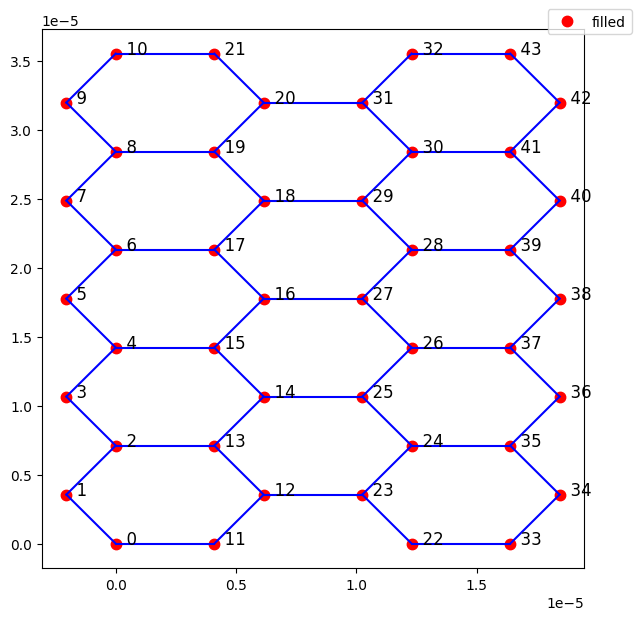

In [161]:
register_1 = get_register(4.1e-6,coords_small)

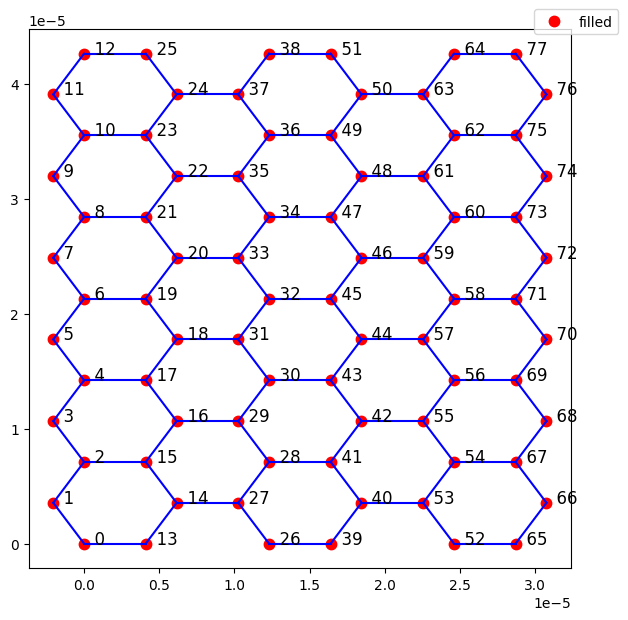

In [ ]:
register_1 = get_register(4.1e-6)

In [108]:
register_1.coordinate_list(1)

[np.float64(0.0),
 np.float64(3.550704155516198e-06),
 np.float64(7.101408311032396e-06),
 np.float64(1.0652112466548595e-05),
 np.float64(1.4202816622064792e-05),
 np.float64(1.775352077758099e-05),
 np.float64(2.130422493309719e-05),
 np.float64(2.4854929088613386e-05),
 np.float64(2.8405633244129584e-05),
 np.float64(3.195633739964578e-05),
 np.float64(3.550704155516198e-05),
 np.float64(3.905774571067818e-05),
 np.float64(4.260844986619438e-05),
 np.float64(0.0),
 np.float64(3.550704155516198e-06),
 np.float64(7.101408311032396e-06),
 np.float64(1.0652112466548595e-05),
 np.float64(1.4202816622064792e-05),
 np.float64(1.775352077758099e-05),
 np.float64(2.130422493309719e-05),
 np.float64(2.4854929088613386e-05),
 np.float64(2.8405633244129584e-05),
 np.float64(3.195633739964578e-05),
 np.float64(3.550704155516198e-05),
 np.float64(3.905774571067818e-05),
 np.float64(4.260844986619438e-05),
 np.float64(0.0),
 np.float64(3.550704155516198e-06),
 np.float64(7.101408311032396e-06),
 n

In [6]:
def get_ahs_program(register,
                    amplitude_min = 0,
                    amplitude_max = 1.57e7,  # rad / s
                    detuning_min = -12.5e7,  # rad / s
                    detuning_max = 12.5e7,  # rad / s
                    t_max = 4e-6, # s
                    t_ramp = 2.5e-7, # s
                   ):
    """Get the AHS program for simulating the ground state of a graphene

    Args:
        register (AtomArrangement): The register for the graphene
        amplitude_min (float): The minimum value of the amplitude
        amplitude_max (float): The maximum value of the amplitude
        detuning_min (float): The minimum value of the detuning
        detuning_max (float): The maximum value of the detuning
        t_max (float): The duration of the annealing schedule
        t_ramp (float): The time spent to ramp amplitude from zero up to its max value

    Returns:
        The AHS program for simulating the ground state of the graphene
    """  
    
    time_points = [0, t_ramp, t_max-t_ramp, t_max] #Is this the correct annealing time?    
    
    amplitude_values = [amplitude_min, amplitude_max, amplitude_max, amplitude_min]  # piecewise linear
    detuning_values = [detuning_min, detuning_min, detuning_max, detuning_max]  # piecewise linear
    phase_values = [0, 0, 0, 0]  # piecewise constant
    
    drive = DrivingField.from_lists(time_points, amplitude_values, detuning_values, phase_values)

    ahs_program = AnalogHamiltonianSimulation(register=register, hamiltonian=drive)

    return ahs_program

In [ ]:
ahs_program_1 = get_ahs_program(register_1)

In [19]:
ahs_program_1

## Run on QuEra
<a id="run"></a>

Fill in from the older notebook.

## Analyse results
<a id="analyse"></a>

In [7]:
# This downloads the results from the cloud
from braket.aws import AwsQuantumTask
import boto3
import os

def get_result_json(arn, data_folder="qpu_data"):
    """Extract the result json from the task 

    Args:
        arn (str): The arn (unique identifier) of the task
        data_folder (str): The folder used to save the json files

    Returns:
        None
    """ 
    
    task = AwsQuantumTask(arn=arn)
    outputS3Bucket = task.metadata()['outputS3Bucket']
    outputS3Directory = task.metadata()['outputS3Directory']

    arn_uuid = arn.split("/")[-1]
    
    try:
        os.mkdir(f'qpu_data/{arn_uuid}/')
    except:
        pass

    with open(f'qpu_data/{arn_uuid}/results.json', 'wb') as f:
        s3.download_fileobj(outputS3Bucket, f'{outputS3Directory}/results.json', f)

        

In [9]:
import json

def get_measurements(arn, data_folder="qpu_data"):
    """Extract the measurement result from the task 

    Args:
        arn (str): The arn (unique identifier) of the task
        data_folder (str): The folder used to save the json files

    Returns:
        preseqs (list[list[int]]): The pre sequence of the result
        postseqs (list[list[int]]): The post sequence of the result

    Notes:
        For more details on pre and post sequence, please refer to the link below
        https://github.com/amazon-braket/amazon-braket-examples/blob/main/examples/analog_hamiltonian_simulation/01_Introduction_to_Aquila.ipynb
    """ 

    arn_uuid = arn.split("/")[-1]    
    folder = f'qpu_data/{arn_uuid}/'

    with open(f'{folder}/results.json', 'r') as f:
        # Load the JSON data into a Python dictionary
        data = json.load(f)

    measurements = data['measurements']
    preseqs = [meas['shotResult']['preSequence'] for meas in measurements]
    postseqs = [meas['shotResult']['postSequence'] for meas in measurements]
    
    return preseqs, postseqs

#### Read the json file

In [10]:
def read_json_results(json_file):
    
    with open(json_file, 'r') as f:
        # Load the JSON data into a Python dictionary
        data = json.load(f)

    measurements = data['measurements']
    preseqs = [meas['shotResult']['preSequence'] for meas in measurements]
    postseqs = [meas['shotResult']['postSequence'] for meas in measurements]
    
    return preseqs, postseqs

In [11]:
def extract_pre_post_sequences(json_file):
    """
    Extracts pre_sequence and post_sequence lists separately from a given JSON structure.

    Parameters:
    json_data (dict): JSON dictionary containing "shot_outputs" with "pre_sequence" and "post_sequence".

    Returns:
    tuple: Two lists - one for all pre_sequences and one for all post_sequences.
    """

    with open(json_file, 'r') as f:
        json_data = json.load(f)

    pre_sequences = []
    post_sequences = []

    for shot in json_data.get("shot_outputs", []):
        pre_sequences.append(shot.get("pre_sequence", []))
        post_sequences.append(shot.get("post_sequence", []))
    
    return pre_sequences, post_sequences

# Extract pre and post sequences separately



In [12]:
def read_all_sequences_from_folder(folder_path):
    """
    Reads all .json files in the given folder and extracts combined pre- and post-sequences.

    Parameters:
        folder_path (str): Path to folder containing JSON files.

    Returns:
        tuple: Two flat lists - concatenated pre_sequences and post_sequences from all files.
    """
    all_pre = []
    all_post = []

    for filename in os.listdir(folder_path):
        if filename.endswith('.json'):
            full_path = os.path.join(folder_path, filename)
            pre, post = extract_pre_post_sequences(full_path)
            # Flatten and concatenate
            for p in pre:
                all_pre.append(p)
            for q in post:
                all_post.append(q)

    return all_pre, all_post

In [35]:
preseqs,postseqs = read_all_sequences_from_folder("qpu_data/4.1micrometers/1250")

In [13]:
def get_hamming(preseqs,postseqs): 
    
    preseqs = np.array(preseqs)
    postseqs = np.array(postseqs)
    
    num_atoms = preseqs.shape[1]
    
    keep_config = np.where(np.sum(preseqs,axis=1) == num_atoms)[0]

    hamming = num_atoms-np.sum(postseqs[keep_config],axis=1)
    len_hamming = len(hamming)
    hamming_average = np.average(hamming)
    hamming_std = np.std(hamming)
    hamming_max = np.max(hamming)
    hamming_min = np.min(hamming)
    
    hamming_unique, unique_index = np.unique(hamming,return_counts=True)
#     print(np.average(np.sum(postseqs[keep_config],axis=1)))
    return len_hamming, hamming_average, hamming_std,hamming_max,hamming_min,hamming_unique, unique_index
    

In [26]:
preseqs_1, postseqs_1 = read_json_results('qpu_data/4micrometers/-125000000/results.json')
preseqs_2, postseqs_2 = read_json_results('qpu_data/5micrometers/-125000000/results.json')
preseqs_3, postseqs_3 = read_json_results('qpu_data/6micrometers/-125000000/results.json')
preseqs_4, postseqs_4 = extract_pre_post_sequences('qpu_data/4.1micrometers/000000000/results.json')
preseqs_5, postseqs_5 = extract_pre_post_sequences('qpu_data/6micrometers/000000000/results.json')
preseqs_6, postseqs_6 = extract_pre_post_sequences('qpu_data/4.1micrometers/1250/results.json')

In [37]:
len_hamming, hamming_average, hamming_std,hamming_max,hamming_min,\
hamming_unique, unique_index = get_hamming(preseqs,postseqs)

print("Hamming Length:", len_hamming)
print("Hamming Average:", hamming_average)
print("Hamming Standard Deviation:", hamming_std)
print("Hamming Max:", hamming_max)
print("Hamming Min:", hamming_min)
print("Hamming Unique Values:", hamming_unique)
print("Unique Index:", unique_index)

Hamming Length: 65
Hamming Average: 6.492307692307692
Hamming Standard Deviation: 2.113131667404325
Hamming Max: 14
Hamming Min: 3
Hamming Unique Values: [ 3  4  5  6  7  8  9 10 12 14]
Unique Index: [ 2 10 13 10  8 12  7  1  1  1]


## Small structures

In [ ]:
def stack_chunks_vertically(arr, chunk_size=28):
    """
    Split a (N, M) array into M/chunk_size horizontal chunks,
    and stack them vertically to shape (N * num_chunks, chunk_size).
    
    Parameters:
        arr (ndarray): Input array of shape (N, M)
        chunk_size (int): Width of each chunk (default is 28)
    
    Returns:
        stacked (ndarray): Output array of shape (N * num_chunks, chunk_size)
    """
    if arr.shape[1] % chunk_size != 0:
        raise ValueError("Array width must be divisible by chunk_size.")

    num_chunks = arr.shape[1] // chunk_size
    chunks = [arr[:, i*chunk_size:(i+1)*chunk_size] for i in range(num_chunks)]
    stacked = np.vstack(chunks)
    return stacked

In [216]:
preseqs,postseqs = read_all_sequences_from_folder("qpu_data/small_structure/4.01micrometers")
preseqs = np.array(preseqs)
postseqs = np.array(postseqs)

preseqs = stack_chunks_vertically(preseqs)
postseqs = stack_chunks_vertically(postseqs)

In [ ]:
len_hamming, hamming_average, hamming_std,hamming_max,hamming_min,\
hamming_unique, unique_index = get_hamming(preseqs,postseqs)



Text(0, 0.5, 'Average conc')

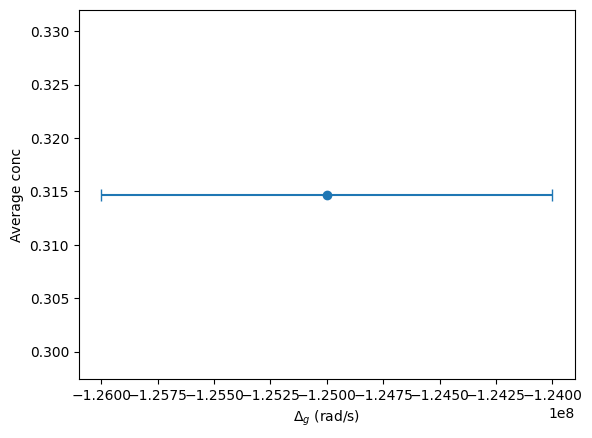

In [223]:
delta_g_all = ['-125000000','-62500000','-12500','-1250','0','1250','62500000','125000000']
delta_g_all = ['125000000']

delta_g_all_int = [-int(x) for x in delta_g_all]

folder = 'qpu_data/small_structure/4micrometers'
datasets = []

for delta_g in delta_g_all: 
    preseqs, postseqs = read_all_sequences_from_folder(os.path.join(folder, delta_g))
    
    preseqs = np.array(preseqs)
    postseqs = np.array(postseqs)

    preseqs = stack_chunks_vertically(preseqs)
    postseqs = stack_chunks_vertically(postseqs)

    datasets.append((preseqs, postseqs, f"Δg = {delta_g}"))

hamming_average_all = []

for preseqs, postseqs, label in datasets:
    # Compute Hamming distances
    len_hamming, hamming_average, hamming_std, hamming_max, \
    hamming_min, hamming_unique, unique_index = get_hamming(preseqs, postseqs)
    
    hamming_average_all.append(hamming_average)

x = np.array(delta_g_all_int)  # wavelength in nm
y = np.array(hamming_average_all)/28  # fake spectrum

fig, ax_bottom = plt.subplots()
ax_bottom.errorbar(
    x, y,
    xerr=1e6,  # ±5e5 rad/s
    fmt='o-', capsize=4,
    label='R=4$\mu$m'
)
ax_bottom.set_xlabel('$\Delta_g$ (rad/s)')
ax_bottom.set_ylabel('Average conc')



# with open("scripts/monte_carlo/results/av_conc_10000000_4.1um.json", "r") as f:
#     data = json.load(f)

# # Plot each temperature's data
# # plt.figure(figsize=(8, 6))

# for T, values in data.items():
#     x = np.array(values["Delta_mu"])*eV_to_rad_s
#     y = np.array(values["avg_conc"])
   
#     ax.plot(x, y,'-',label=f'B {float(T):.3e}')


# ax.legend()

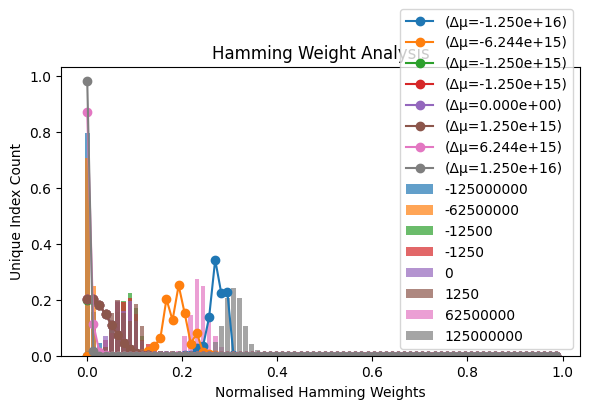

In [63]:
import matplotlib.pyplot as plt

# Define input datasets
# datasets = [
#     # (preseqs_1, postseqs_1, "4 micrometer"),
#     # (preseqs_2, postseqs_2, "5 micrometer"),
#     # (preseqs_3, postseqs_3, "6 micrometer"),
#     (preseqs_4, postseqs_4, "4.1 micro GD=0"),
#     (preseqs_5, postseqs_5, "6 micro GD=0"),
#     (preseqs_6, postseqs_6, "4.1 micro GD=1250")
# ]
folder = '/Users/brunocamino/Desktop/UCL/rydberg_atoms/qpu_data/4.1micrometers/'
datasets = []
delta_g_all = ['-125000000','-62500000','-12500','-1250','0','1250','62500000','125000000']
# delta_g_all = ['-125000000','-12500','0','62500000','125000000']
for delta_g in delta_g_all: 
    preseqs, postseqs = read_all_sequences_from_folder(os.path.join(folder,delta_g))
    datasets.append((preseqs, postseqs, f"{delta_g}"))

num_sites = 78  # Normalization factor for the x-axis

# Create a single subplot
fig, ax = plt.subplots(figsize=(6,4))

hamming_average_all = []
for preseqs, postseqs, label in datasets:
    # Compute Hamming distances
    len_hamming, hamming_average, hamming_std, hamming_max, \
    hamming_min, hamming_unique, unique_index = get_hamming(preseqs, postseqs)
    
    hamming_average_all.append(hamming_average)

    # Normalize the x-axis by num_sites
    normalized_x = [x / num_sites for x in hamming_unique]
    
    # Plot data
    ax.bar(normalized_x, unique_index/len_hamming, alpha=0.7, width=0.01, label=label)
# # Load the CSV with previously saved concentration vs probability data
df = pd.read_csv("data/Monte_carlo/concentration_distribution_vs_Delta_mu.csv")

# The first column is concentration
concentration = np.array(df.iloc[:, 0].values)

# Loop over each Delta_mu column
for col in df.columns[1:]:
    y = df[col].values  # Probability
    # print(col)
    label = f"(Δμ={float(col[:-4])*eV_to_rad_s:.3e})"
    ax.plot(concentration/num_sites, y,'o-', label=label)

# ax.set_xlim((-1,30))
# Improve plot aesthetics
ax.set_xlabel("Normalised Hamming Weights")
ax.set_ylabel("Unique Index Count")
ax.set_title("Hamming Weight Analysis")
ax.legend()
fig.tight_layout()

plt.show()

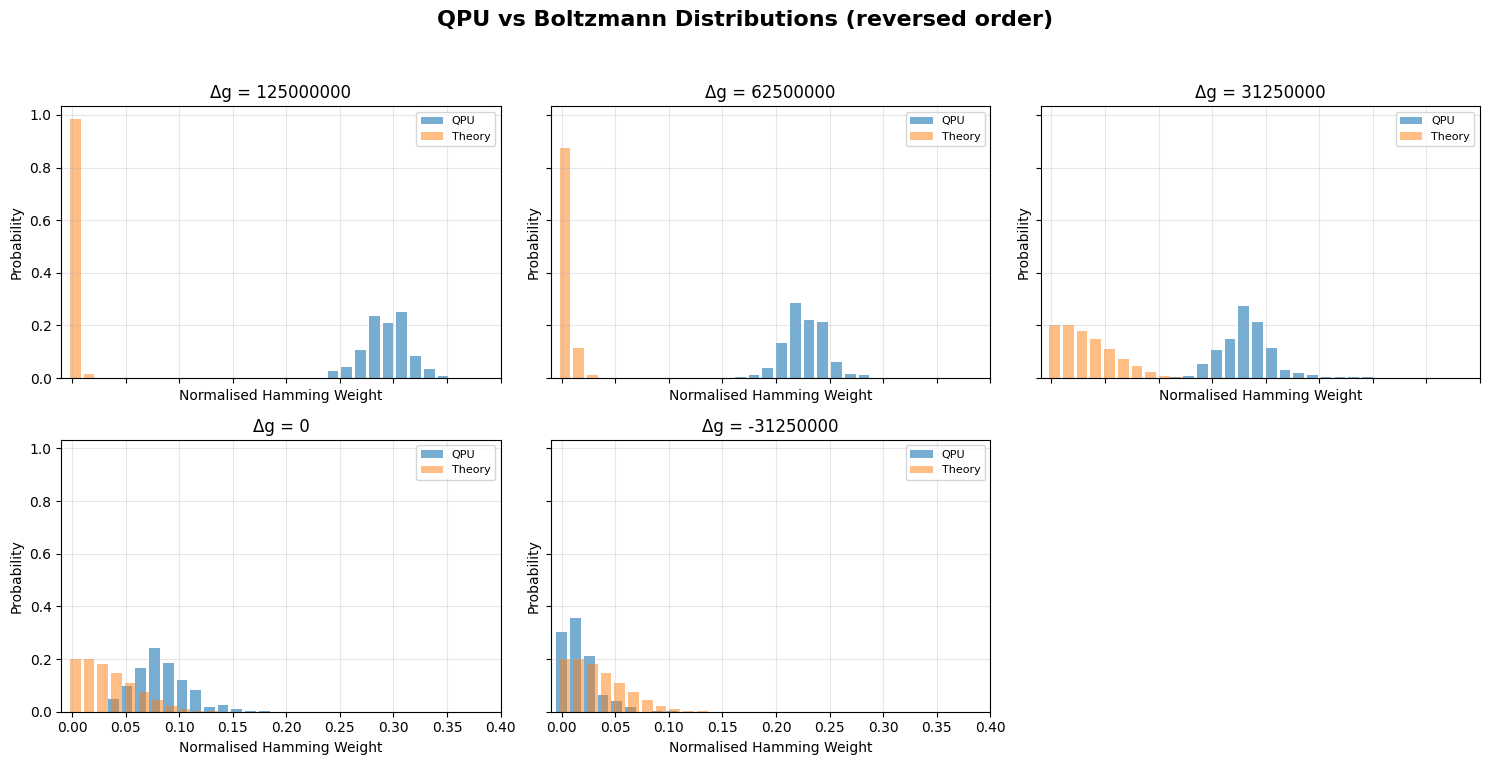

In [220]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import math

# Load theoretical data
df = pd.read_csv("data/Monte_carlo/concentration_distribution_vs_Delta_mu.csv")
concentration = np.array(df.iloc[:, 0].values)
theory_columns = df.columns[1:][::-1]  # reverse the columns (skip concentration)

# Define input datasets
folder = '/Users/brunocamino/Desktop/UCL/rydberg_atoms/qpu_data/4micrometers/'
datasets = []
delta_g_all = ['125000000','62500000','31250000','0','-31250000']

for delta_g in delta_g_all: 
    preseqs, postseqs = read_all_sequences_from_folder(os.path.join(folder, delta_g))
    datasets.append((preseqs, postseqs, f"Δg = {delta_g}"))

num_sites = 78

# Subplot layout
n = len(datasets)
cols = 3
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), sharex=True, sharey=True)
axes = axes.flatten()

hamming_average_all = []

for idx, (preseqs, postseqs, label) in enumerate(datasets):
    ax = axes[idx]

    # Compute Hamming distances
    len_hamming, hamming_average, hamming_std, hamming_max, \
    hamming_min, hamming_unique, unique_index = get_hamming(preseqs, postseqs)
    
    hamming_average_all.append(hamming_average)

    normalized_x_qpu = [x / num_sites for x in hamming_unique]
    y_qpu = unique_index / len_hamming

    # Plot QPU data as bars
    ax.bar(normalized_x_qpu, y_qpu, alpha=0.6, width=0.01, label='QPU')

    # Plot corresponding reversed theory column
    if idx < len(theory_columns):
        col = theory_columns[idx]
        y_theory = df[col].values
        normalized_x_theory = concentration / num_sites

        # Offset theory bars to avoid overlap
        ax.bar(normalized_x_theory + 0.003, y_theory, alpha=0.5, width=0.01, label='Theory')

    ax.set_title(label)
    ax.set_xlabel("Normalised Hamming Weight")
    ax.set_ylabel("Probability")
    ax.set_xlim(-0.01, 0.4)  # ✅ set max x limit
    ax.grid(alpha=0.3)
    ax.legend(fontsize=8)

# Hide any unused subplots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("QPU vs Boltzmann Distributions (reversed order)", fontsize=16, fontweight='bold')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [100]:
1000000/eV_to_rad_s

6.58197854274995e-10

In [106]:
20000000/eV_to_rad_s

1.3163957085499902e-08

[ 1.25000000e+08  9.72222222e+07  6.94444444e+07  4.16666667e+07
  1.38888889e+07 -1.38888889e+07 -4.16666667e+07 -6.94444444e+07
 -9.72222222e+07 -1.25000000e+08]


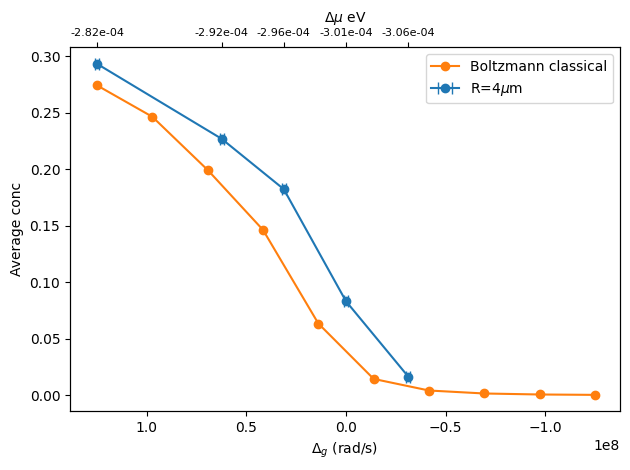

In [221]:
delta_g_all = ['125000000','62500000','31250000','0','-31250000']
delta_g_all_int = [int(x) for x in delta_g_all]

C6 = 5.42e-24  # C6 constant in rad m^6 / s
eV_to_rad_s = 1.5193e+15 
reg_coef = [0.00030122447260882713, 0.00020350836925458785]
V_2um = (C6/(4e-6**6))
V_qubo = reg_coef[1]*eV_to_rad_s
V_ratio = V_qubo/V_2um

Delta_g_qubo = reg_coef[0]*eV_to_rad_s
Delta_g_hardware_all = delta_g_all_int
x = np.array(Delta_g_hardware_all)  # wavelength in nm
y = np.array(hamming_average_all)/num_sites  # fake spectrum

fig, ax_bottom = plt.subplots()
ax_bottom.errorbar(
    x, y,
    xerr=1e6,  # ±5e5 rad/s
    fmt='o-', capsize=4,
    label='R=4$\mu$m'
)
ax_bottom.set_xlabel('$\Delta_g$ (rad/s)')
ax_bottom.set_ylabel('Average conc')


# Invert x-axis here
ax_bottom.invert_xaxis()
data = np.loadtxt('data/Monte_carlo/average_conc_Boltzmann_1K_Vr.csv', delimiter=',', skiprows=1)
# data = np.loadtxt('data/Monte_carlo/average_conc_Boltzmann_hardware_1K_Vr.csv', delimiter=',', skiprows=1)
# Split into x and y vectors
x_data = data[:, 0][::-1]  # Delta_mu (rad/s) (manually invert x axis)
y_data = data[:, 1]  # Average_conc
# print(x_data)
# x_data = np.array(x_data)-20000000

print(x_data)
ax_bottom.plot(x_data, y_data,'o-',label='Boltzmann classical')

# Top axis: energy in eV
ax_top = ax_bottom.twiny()

# Sync top axis with inverted bottom axis
ax_top.set_xlim(ax_bottom.get_xlim())

# Set custom ticks based on energy
Delta_g_hardware_ticks = copy.deepcopy(Delta_g_hardware_all)
Delta_mu_ticks = [(-Delta_g_qubo + Delta_g_hardware * V_ratio) / eV_to_rad_s 
                  for Delta_g_hardware in np.array(Delta_g_hardware_all)]

ax_top.set_xticks(Delta_g_hardware_ticks)
ax_top.set_xticklabels([f"{e:.2e}" for e in Delta_mu_ticks], fontsize=8)
ax_top.set_xlabel("$\Delta\mu$ eV")
ax_bottom.legend()
plt.tight_layout()
plt.show()

In [146]:
delta_g_all_int

[125000000, 62500000, 12500, 1250, 0, -1250, -62500000, -125000000]

In [126]:
np.array(Delta_g_hardware_all)

array([-125000000,  -62500000,     -12500,      -1250,          0,
             1250,   62500000,  125000000])

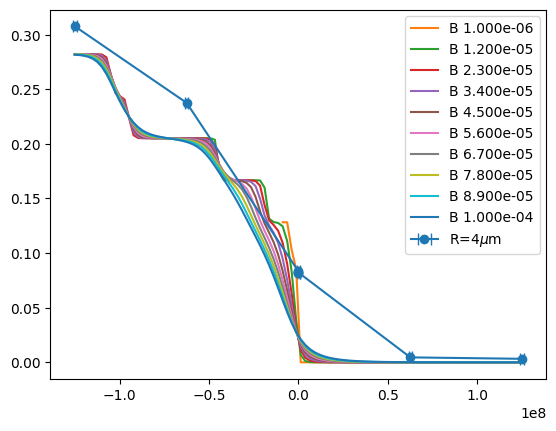

In [143]:
delta_g_all = ['-125000000','-62500000','-12500','-1250','0','1250','62500000','125000000']
delta_g_all_int = [-int(x) for x in delta_g_all]

# C6 = 5.42e-24  # C6 constant in rad m^6 / s
# eV_to_rad_s = 1.5193e+15 
# reg_coef = [0.00030122447260882713, 0.00020350836925458785]
# V_2um = (C6/(4e-6**6))
# V_qubo = reg_coef[1]*eV_to_rad_s
# V_ratio = V_qubo/V_2um

# Delta_g_qubo = reg_coef[0]*eV_to_rad_s
Delta_g_hardware_all = delta_g_all_int
x = np.array(Delta_g_hardware_all)  # wavelength in nm
y = np.array(hamming_average_all)/num_sites  # fake spectrum

fig, ax = plt.subplots()
ax.errorbar(
    x, y,
    xerr=1e6,  # ±5e5 rad/s
    fmt='o-', capsize=4,
    label='R=4$\mu$m'
)
# ax_bottom.set_xlabel('$\Delta_g$ (rad/s)')
# ax_bottom.set_ylabel('Average conc')


with open("scripts/monte_carlo/results/av_conc_10000000_4.1um.json", "r") as f:
    data = json.load(f)

# Plot each temperature's data
# plt.figure(figsize=(8, 6))

for T, values in data.items():
    x = np.array(values["Delta_mu"])*eV_to_rad_s
    y = np.array(values["avg_conc"])
   
    ax.plot(x, y,'-',label=f'B {float(T):.3e}')


ax.legend()

# # Top axis: energy in eV
# ax_top = ax_bottom.twiny()

# # Sync top axis with inverted bottom axis
# ax_top.set_xlim(ax_bottom.get_xlim())

# # Set custom ticks based on energy
# Delta_g_hardware_ticks = copy.deepcopy(Delta_g_hardware_all)
# Delta_mu_ticks = [(-Delta_g_qubo + Delta_g_hardware * V_ratio) / eV_to_rad_s 
#                   for Delta_g_hardware in np.array(Delta_g_hardware_all)]

# ax_top.set_xticks(Delta_g_hardware_ticks)
# ax_top.set_xticklabels([f"{e:.2e}" for e in Delta_mu_ticks], fontsize=8)
# ax_top.set_xlabel("$\Delta\mu$ eV")
# ax_bottom.legend()
# plt.tight_layout()
# plt.show()

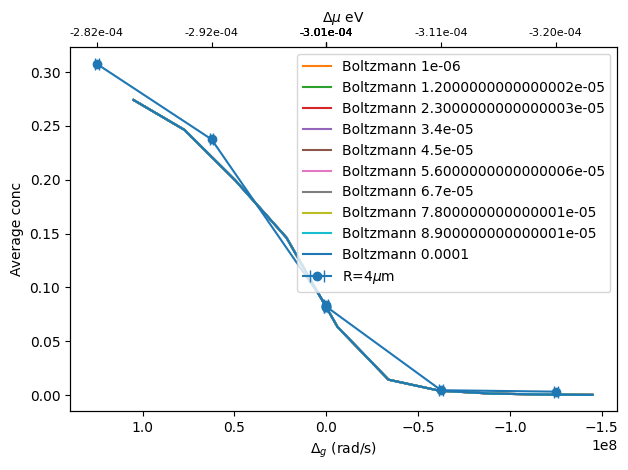

In [ ]:
delta_g_all = ['-125000000','-62500000','-12500','-1250','0','1250','62500000','125000000']
delta_g_all_int = [int(x) for x in delta_g_all]

C6 = 5.42e-24  # C6 constant in rad m^6 / s
eV_to_rad_s = 1.5193e+15 
reg_coef = [0.00030122447260882713, 0.00020350836925458785]
V_2um = (C6/(4e-6**6))
V_qubo = reg_coef[1]*eV_to_rad_s
V_ratio = V_qubo/V_2um

Delta_g_qubo = reg_coef[0]*eV_to_rad_s
Delta_g_hardware_all = delta_g_all_int
x = np.array(Delta_g_hardware_all)  # wavelength in nm
y = np.array(hamming_average_all)/num_sites  # fake spectrum

fig, ax_bottom = plt.subplots()
ax_bottom.errorbar(
    x, y,
    xerr=1e6,  # ±5e5 rad/s
    fmt='o-', capsize=4,
    label='R=4$\mu$m'
)
ax_bottom.set_xlabel('$\Delta_g$ (rad/s)')
ax_bottom.set_ylabel('Average conc')


# Invert x-axis here
ax_bottom.invert_xaxis()
# data = np.loadtxt('data/Monte_carlo/average_conc_Boltzmann_1K_Vr.csv', delimiter=',', skiprows=1)
# # data = np.loadtxt('data/Monte_carlo/average_conc_Boltzmann_hardware_1K_Vr.csv', delimiter=',', skiprows=1)
# # Split into x and y vectors
# x_data = data[:, 0][::-1]  # Delta_mu (rad/s) (manually invert x axis)
# y_data = data[:, 1]  # Average_conc
# print(x_data)
# x_data = np.array(x_data)-20000000

with open("scripts/monte_carlo/results/av_conc_1000000_4.1um.json", "r") as f:
    data = json.load(f)

# Plot each temperature's data
# plt.figure(figsize=(8, 6))

for T, values in data.items():
    x = np.array(values["Delta_mu"])*eV_to_rad_s
    y = np.array(values["avg_conc"])
    ax_bottom.plot(x_data, y_data,'-',label=f'Boltzmann {T}')




# Top axis: energy in eV
ax_top = ax_bottom.twiny()

# Sync top axis with inverted bottom axis
ax_top.set_xlim(ax_bottom.get_xlim())

# Set custom ticks based on energy
Delta_g_hardware_ticks = copy.deepcopy(Delta_g_hardware_all)
Delta_mu_ticks = [(-Delta_g_qubo + Delta_g_hardware * V_ratio) / eV_to_rad_s 
                  for Delta_g_hardware in np.array(Delta_g_hardware_all)]

ax_top.set_xticks(Delta_g_hardware_ticks)
ax_top.set_xticklabels([f"{e:.2e}" for e in Delta_mu_ticks], fontsize=8)
ax_top.set_xlabel("$\Delta\mu$ eV")
ax_bottom.legend()
plt.tight_layout()
plt.show()